## Plots - ZTF
In this notebook, we take outputs from our run on two weeks worth of ZTF alerts and make a series of plots for the 
THOR paper. 

[Survey Footprint [Fig 7]](#Survey-Footprint)   
[Completeness [Fig 8]](#Completeness)  
[Cluster Summary](#Cluster-Summary)

This notebook creates Figures 7 and 8.

Data and results files for this notebook may be downloaded [here](https://dirac.astro.washington.edu/~moeyensj/projects/thor/paper1/).

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

import mysql.connector as mariadb
from astropy.time import Time

from scipy.stats import binned_statistic_2d

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("/epyc/projects/thor/thor")

In [2]:
import thor

In [3]:
DPI = 300
SAVE_DIR = "plots/"
FORMAT = "png"

SAVE_FIGS = True

In [4]:
columnMapping = {    
    
        # Observation ID
        "obs_id" : "obs_id",
        
        # Exposure time
        "exp_mjd" : "exp_mjd",
        
        # Visit ID
        "visit_id" : "visit_id",
        
        # Field ID
        "field_id" : "field",
        
        # Field RA in degrees
        "field_RA_deg" : "fieldRA_deg",
        
        # Field Dec in degrees
        "field_Dec_deg" : "fieldDec_deg",
        
        # Night number
        "night": "nid",
        
        # RA in degrees
        "RA_deg" : "ra",
        
        # Dec in degrees
        "Dec_deg" : "decl",
        
        # Observer's x coordinate in AU
        "obs_x_au" : "HEclObsy_X_au",
        
        # Observer's y coordinate in AU
        "obs_y_au" : "HEclObsy_Y_au",
        
        # Observer's z coordinate in AU
        "obs_z_au" : "HEclObsy_Z_au",
        
        # Magnitude (UNUSED)
        "mag" : "magpsf",
        
        ### Truth Parameters
        
        # Object name
        "name" : "designation",
        
        # Observer-object distance in AU
        "Delta_au" : "Delta_au",
        
        # Sun-object distance in AU (heliocentric distance)
        "r_au" : "r_au",
        
        # Object's x coordinate in AU
        "obj_x_au" : "HEclObj_X_au",
        
        # Object's y coordinate in AU
        "obj_y_au" : "HEclObj_Y_au",
        
        # Object's z coordinate in AU
        "obj_z_au" : "HEclObj_Z_au",
        
        # Object's x velocity in AU per day
        "obj_dx/dt_au_p_day" : "HEclObj_dX/dt_au_p_day",
        
        # Object's y velocity in AU per day
        "obj_dy/dt_au_p_day" : "HEclObj_dY/dt_au_p_day",
        
        # Object's z velocity in AU per day
        "obj_dz/dt_au_p_day" : "HEclObj_dZ/dt_au_p_day",
        
        # Semi-major axis
        "a_au" : "a_au",
        
        # Inclination
        "i_deg" : "i_deg",
        
        # Eccentricity
        "e" : "e",
}

In [5]:
RUN_DIR = "/epyc/projects/thor/results/ztf/run_16/"
# MPC orbit catalog copy is also saved in simulations database
DATABASE = "/epyc/projects/thor/data/msst_4x4/msst_survey.db"
con = sql.connect(DATABASE)

In [6]:
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)
summary_survey = pd.read_csv(os.path.join(RUN_DIR, "summary_survey.txt"), sep=" ", index_col=False)
summary_orbits = pd.read_csv(os.path.join(RUN_DIR, "summary_orbits.txt"), sep=" ", index_col=False)
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)

known_orbits = pd.read_sql("SELECT * FROM mpcOrbitCat", con)
known_orbits = known_orbits[known_orbits["designation"].isin(allObjects_survey["designation"].values)]

In [7]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

falsePositiveIDs = []
unknownIDs = [-1, "-1"]

In [8]:
DATA_DIR = "/epyc/projects/thor/data/ztf"

simulated_ephemeris = thor.readEPHFile(os.path.join(DATA_DIR, "MPCORB_20181106_ZTF.eph"))
orbits = thor.readORBFile(os.path.join(DATA_DIR, "MPCORB_20181106_ZTF_keplerian.orb"), elementType="keplerian")
observations = pd.read_csv(os.path.join(DATA_DIR, "observations_nid_610_624.txt"), sep=" ", index_col=False, low_memory=False)

observations.sort_values(by="mjd", inplace=True)
observations.loc[observations["designation"].isna(), "designation"] = -1

### Survey Footprint 

In [9]:
size = 15
ras = np.arange(-180, 180 + size, size)
decs = np.arange(-90, 90 + size, size)

[-200. -150. -100.  -50.    0.   50.  100.  150.  200.]


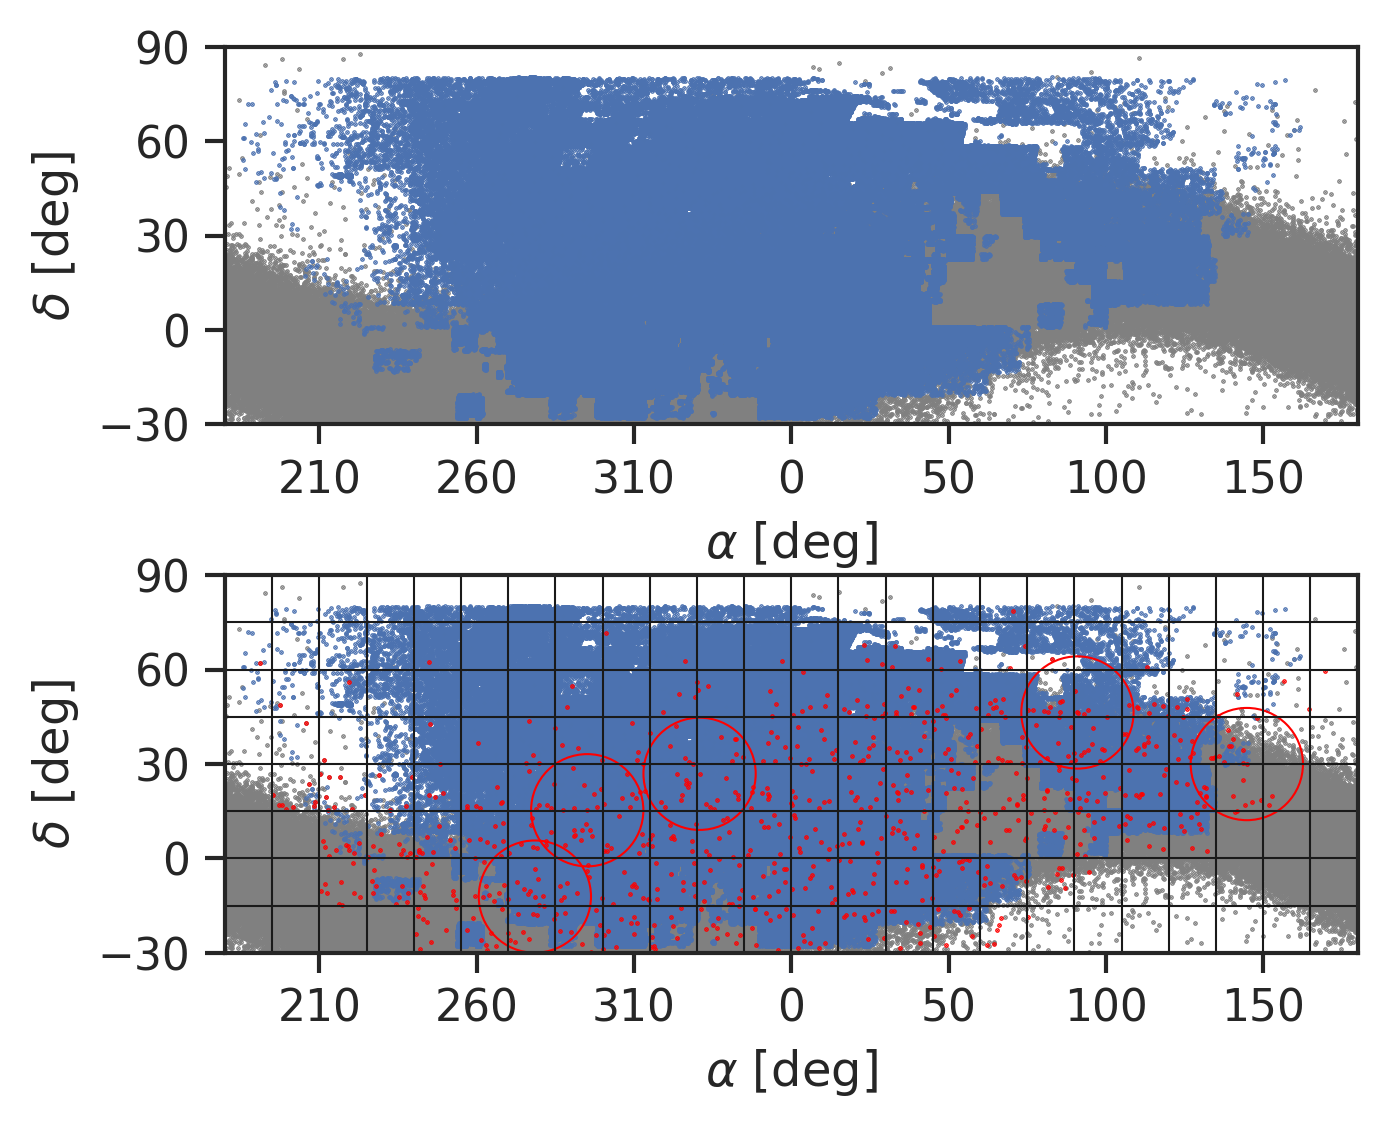

In [10]:
fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 4))
fig.subplots_adjust(hspace=0.4)

eph_ra = simulated_ephemeris["RA_deg"].values
eph_ra = np.where(eph_ra > 180, eph_ra - 360.0, eph_ra)
obs_ra = observations[columnMapping["RA_deg"]].values
obs_ra = np.where(obs_ra > 180, obs_ra - 360.0, obs_ra)

ax[0].scatter(eph_ra, 
              simulated_ephemeris["Dec_deg"].values,
              s=0.1,
              c="#808080")
ax[0].scatter(obs_ra,
              observations[columnMapping["Dec_deg"]].values,
           s=0.1,
           c="b")
ax[0].set_aspect("equal")
ax[0].set_xlabel(r"$\alpha$ [$\deg$]")
ax[0].set_ylabel(r"$\delta$ [$\deg$]")
ax[0].set_ylim(-30, 90)
ax[0].set_xlim(-180, 180)
#ax[0].set_xticks([0, 60, 120, 180, 240, 300, 360])
ticks = ax[0].get_xticks()
ticks[ticks < 0] += 360
ax[0].set_xticklabels([int(tick) for tick in ticks])
ax[0].set_yticks([-30, 0, 30, 60, 90])

test_orb_ra = test_orbits_survey[columnMapping["RA_deg"]].values
test_orb_ra = np.where(test_orb_ra > 180, test_orb_ra - 360.0, test_orb_ra)

ax[1].scatter(eph_ra, 
              simulated_ephemeris["Dec_deg"].values,
              s=0.1,
              c="#808080")
ax[1].scatter(obs_ra, 
           observations[columnMapping["Dec_deg"]].values,
           s=0.1,
           c="b")
ax[1].scatter(test_orb_ra, 
             test_orbits_survey[columnMapping["Dec_deg"]].values,
             s=0.1,
             c="red")
for ra, dec in test_orbits_survey[test_orbits_survey["orbit_id"].isin([10, 49, 103, 155, 201])][["ra", "decl"]].values:
    if ra > 180:
        ra -= 360.0
    ax[1].add_patch(patches.Circle([ra, dec], np.sqrt(1000/np.pi), fill=False, lw=0.5, color="red"))

ax[1].hlines(decs, -180, 180, lw=0.5)
ax[1].vlines(ras, -30, 90, lw=0.5)
ax[1].set_aspect("equal")
ax[1].set_xlabel(r"$\alpha$ [$\deg$]")
ax[1].set_ylabel(r"$\delta$ [$\deg$]")
ax[1].set_ylim(-30, 90)
ax[1].set_xlim(-180, 180)
#ax[1].set_xticks([-180, -120, -60, 0 , 60, 120, 180])
ticks = ax[1].get_xticks()
print(ticks)
ticks[ticks < 0] += 360
ax[1].set_xticklabels([int(tick) for tick in ticks])
ax[1].set_yticks([-30, 0, 30, 60, 90])
if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "ztf_footprint.{}".format(FORMAT)),
            bbox_inches='tight')

### Completeness

In [11]:
from thor import Config

def plotCompleteness(allObjects, orbits, testOrbits=None, columnMapping=Config.columnMapping, testOrbitScatterKwargs={"s": 2, "c": "red"}):
    
    findable = allObjects[allObjects["findable"] == 1]["designation"].values
    found = allObjects[allObjects["found"] == 1]["designation"].values
    missed = allObjects[(allObjects["found"] == 0) & (allObjects_survey["findable"] == 1)]["designation"].values

    BINS = 50
    RANGE_AI = [[0.5, 5.5], [0, 50]]
    RANGE_AE = [RANGE_AI[0], [0, 1]]
    LEVELS = [10, 100, 1000]

    # Calculate 2D binned statistics:
    # X_ai: orbital distribution in a and i
    # N_ai : number of objects discoverable in same bins as X_ai
    X_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS)

    N_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS)
    
    stat_ai = X_ai.statistic.T / N_ai.statistic.T * 100.0
    counts_ai = N_ai.statistic.T
    stat_ai=np.ma.masked_where(stat_ai==np.NaN, stat_ai)
    
    # Calculate 2D binned statistics:
    # X_ae: orbital distribution in a and e
    # N_ae : number of objects discoverable in same bins as X_ai
    X_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS)

    N_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS)

    stat_ae = X_ae.statistic.T / N_ae.statistic.T * 100.0
    counts_ae = N_ae.statistic.T
    stat_ae=np.ma.masked_where(stat_ae==np.NaN, stat_ae)
    
    # Make the figure
    fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 9))
    fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.15,  
        # the right side of the subplots of the figure
        right=1.0,
        # the bottom of the subplots of the figure
        bottom=0.2,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.01,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
                       
    
    # Set NaN values in stat to be white 
    cmap = matplotlib.cm.viridis
    cmap.set_bad('w', np.NaN)

    # Plot a-i completeness
    cm1 = ax[0].imshow(stat_ai, 
                   origin="lower", 
                   cmap=cmap,
                   interpolation='none',
                   aspect="auto",
                   extent=[X_ai.x_edge[0], X_ai.x_edge[-1], X_ai.y_edge[0], X_ai.y_edge[-1]])

    # Add contours
    cs1 = ax[0].contour(counts_ai, 
                    LEVELS, 
                    origin="lower", 
                    extent=[N_ai.x_edge[0], N_ai.x_edge[-1], N_ai.y_edge[0], N_ai.y_edge[-1]],
                    colors="red",
                    linewidths=1)
    plt.clabel(cs1, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[0].set_ylabel("Inclination ($i$) [$\deg$]")
    ax[0].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[0].set_xlim(*RANGE_AI[0])
    ax[0].set_ylim(*RANGE_AI[1])

    # Plot a-e completeness
    cm2 = ax[1].imshow(stat_ae, 
                   origin="lower", 
                   cmap=cmap,
                   interpolation='none',
                   aspect="auto",
                   #norm=colors.LogNorm(),
                   extent=[X_ae.x_edge[0], X_ae.x_edge[-1], X_ae.y_edge[0], X_ae.y_edge[-1]])
    
    # Plot test orbits 
    if type(testOrbits) == pd.DataFrame:
        # If test orbits exist in known orbits, plot them
        test_orbits_in_known = orbits[orbits[columnMapping["name"]].isin(testOrbits[columnMapping["name"]].values)]
        if len(test_orbits_in_known) != 0:
            ax[0].scatter(*test_orbits_in_known[[columnMapping["a_au"], columnMapping["i_deg"]]].values.T, 
                       label="Test Orbits",
                       zorder=10,
                       **testOrbitScatterKwargs)
            
            ax[1].scatter(*test_orbits_in_known[[columnMapping["a_au"], columnMapping["e"]]].values.T, 
                       label="Test Orbits",
                       zorder=10,
                       **testOrbitScatterKwargs)

    # Add contours
    cs2 = ax[1].contour(counts_ae, 
                    LEVELS, 
                    origin="lower", 
                    extent=[N_ae.x_edge[0], N_ae.x_edge[-1], N_ae.y_edge[0], N_ae.y_edge[-1]],
                    colors="red",
                    linewidths=1)
    plt.clabel(cs2, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[1].set_ylabel("Eccentricity ($e$)")
    ax[1].set_xlabel("Semi-Major Axis ($a$) [au]")
    ax[1].set_xlim(*RANGE_AE[0])
    ax[1].set_ylim(*RANGE_AE[1])
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.65, 0.02])
    fig.colorbar(cm2, 
                 cax=cbar_ax, 
                 label="Completeness [%]", 
                 format="%1i", 
                 orientation="horizontal")
     
    return fig, ax 

/epyc/projects/thor/envs/thor_py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

invalid value encountered in true_divide

/epyc/projects/thor/envs/thor_py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning:

invalid value encountered in true_divide



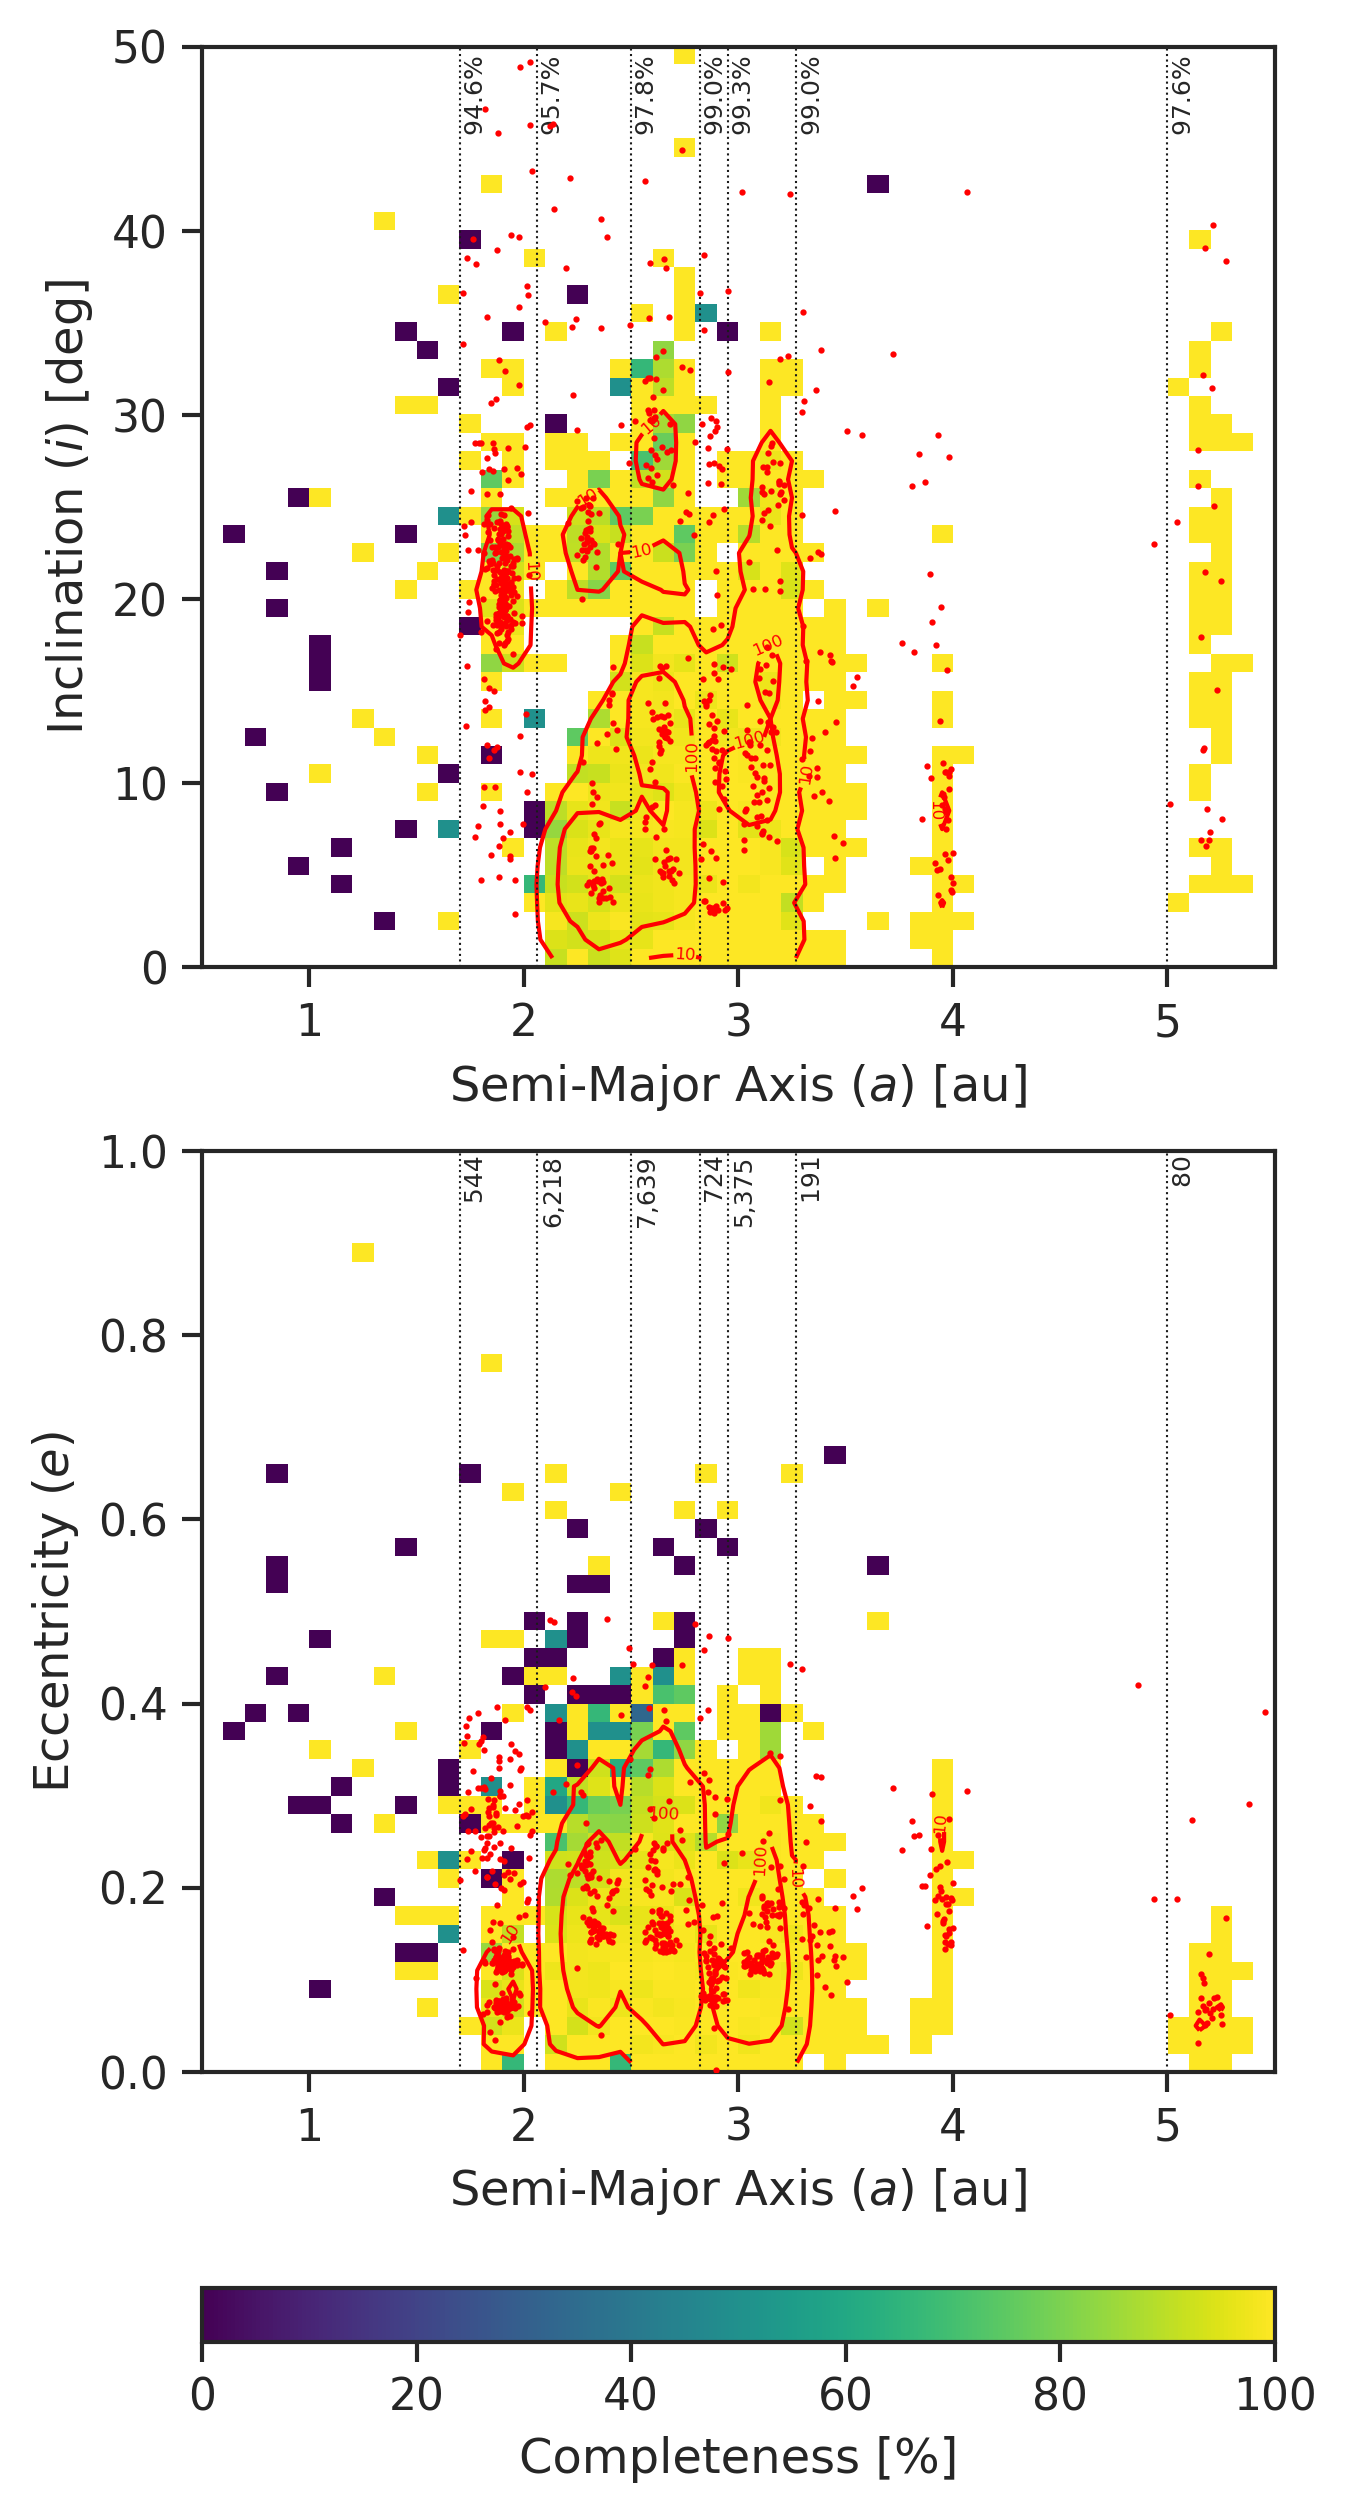

In [12]:
fig, ax = plotCompleteness(allObjects_survey, 
                 orbits, 
                 testOrbits=orbits[orbits["designation"].isin(test_orbits)],
                 testOrbitScatterKwargs={"s": 0.5, "c": "red"},
                 columnMapping=columnMapping)
ax[0].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[1].vlines([1.7, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 50, lw=0.5, linestyle=":")
ax[0].text(1.72, 48.5, " 94.6%", fontsize=6, rotation='vertical')
ax[0].text(2.08, 48.5, " 95.7%", fontsize=6, rotation='vertical')
ax[0].text(2.52, 48.5, " 97.8%", fontsize=6, rotation='vertical')
ax[0].text(2.84, 48.5, " 99.0%", fontsize=6, rotation='vertical')
ax[0].text(2.97, 48.5, " 99.3%", fontsize=6, rotation='vertical')
ax[0].text(3.29, 48.5, " 99.0%", fontsize=6, rotation='vertical')
ax[0].text(5.02, 48.5, " 97.6%", fontsize=6, rotation='vertical')

ax[1].text(1.72, 0.975, "  544", fontsize=6, rotation='vertical')
ax[1].text(2.08, 0.975, "6,218", fontsize=6, rotation='vertical')
ax[1].text(2.52, 0.975, "7,639", fontsize=6, rotation='vertical')
ax[1].text(2.84, 0.975, "  724", fontsize=6, rotation='vertical')
ax[1].text(2.97, 0.975, "5,375", fontsize=6, rotation='vertical')
ax[1].text(3.29, 0.975, "  191", fontsize=6, rotation='vertical')
ax[1].text(5.02, 0.975, "   80", fontsize=6, rotation='vertical')

if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "ztf_a_ie_completeness.{}".format(FORMAT)),
            bbox_inches='tight')

### Cluster Summary

In [13]:
allClusters_projection = []
allObjects_projection = []
for i in range(821):
    try:
        allClusters_projection.append(pd.read_csv(os.path.join(RUN_DIR, "orbit_{:04d}/allClusters.txt".format(i + 1)), sep=" ", index_col=False, low_memory=False))
        allObjects_projection.append(pd.read_csv(os.path.join(RUN_DIR, "orbit_{:04d}/allObjects.txt".format(i + 1)), sep=" ", index_col=False, low_memory=False))
    except:
        continue
    
allClusters_projection = pd.concat(allClusters_projection)
allObjects_projection = pd.concat(allObjects_projection)

allClusters_projection.loc[allClusters_projection["linked_object"].isin([-1]), "linked_object"] = "-1"
allClusters_projection["num_dupes"] = allClusters_projection["num_obs"] - allClusters_projection["num_visits"] 

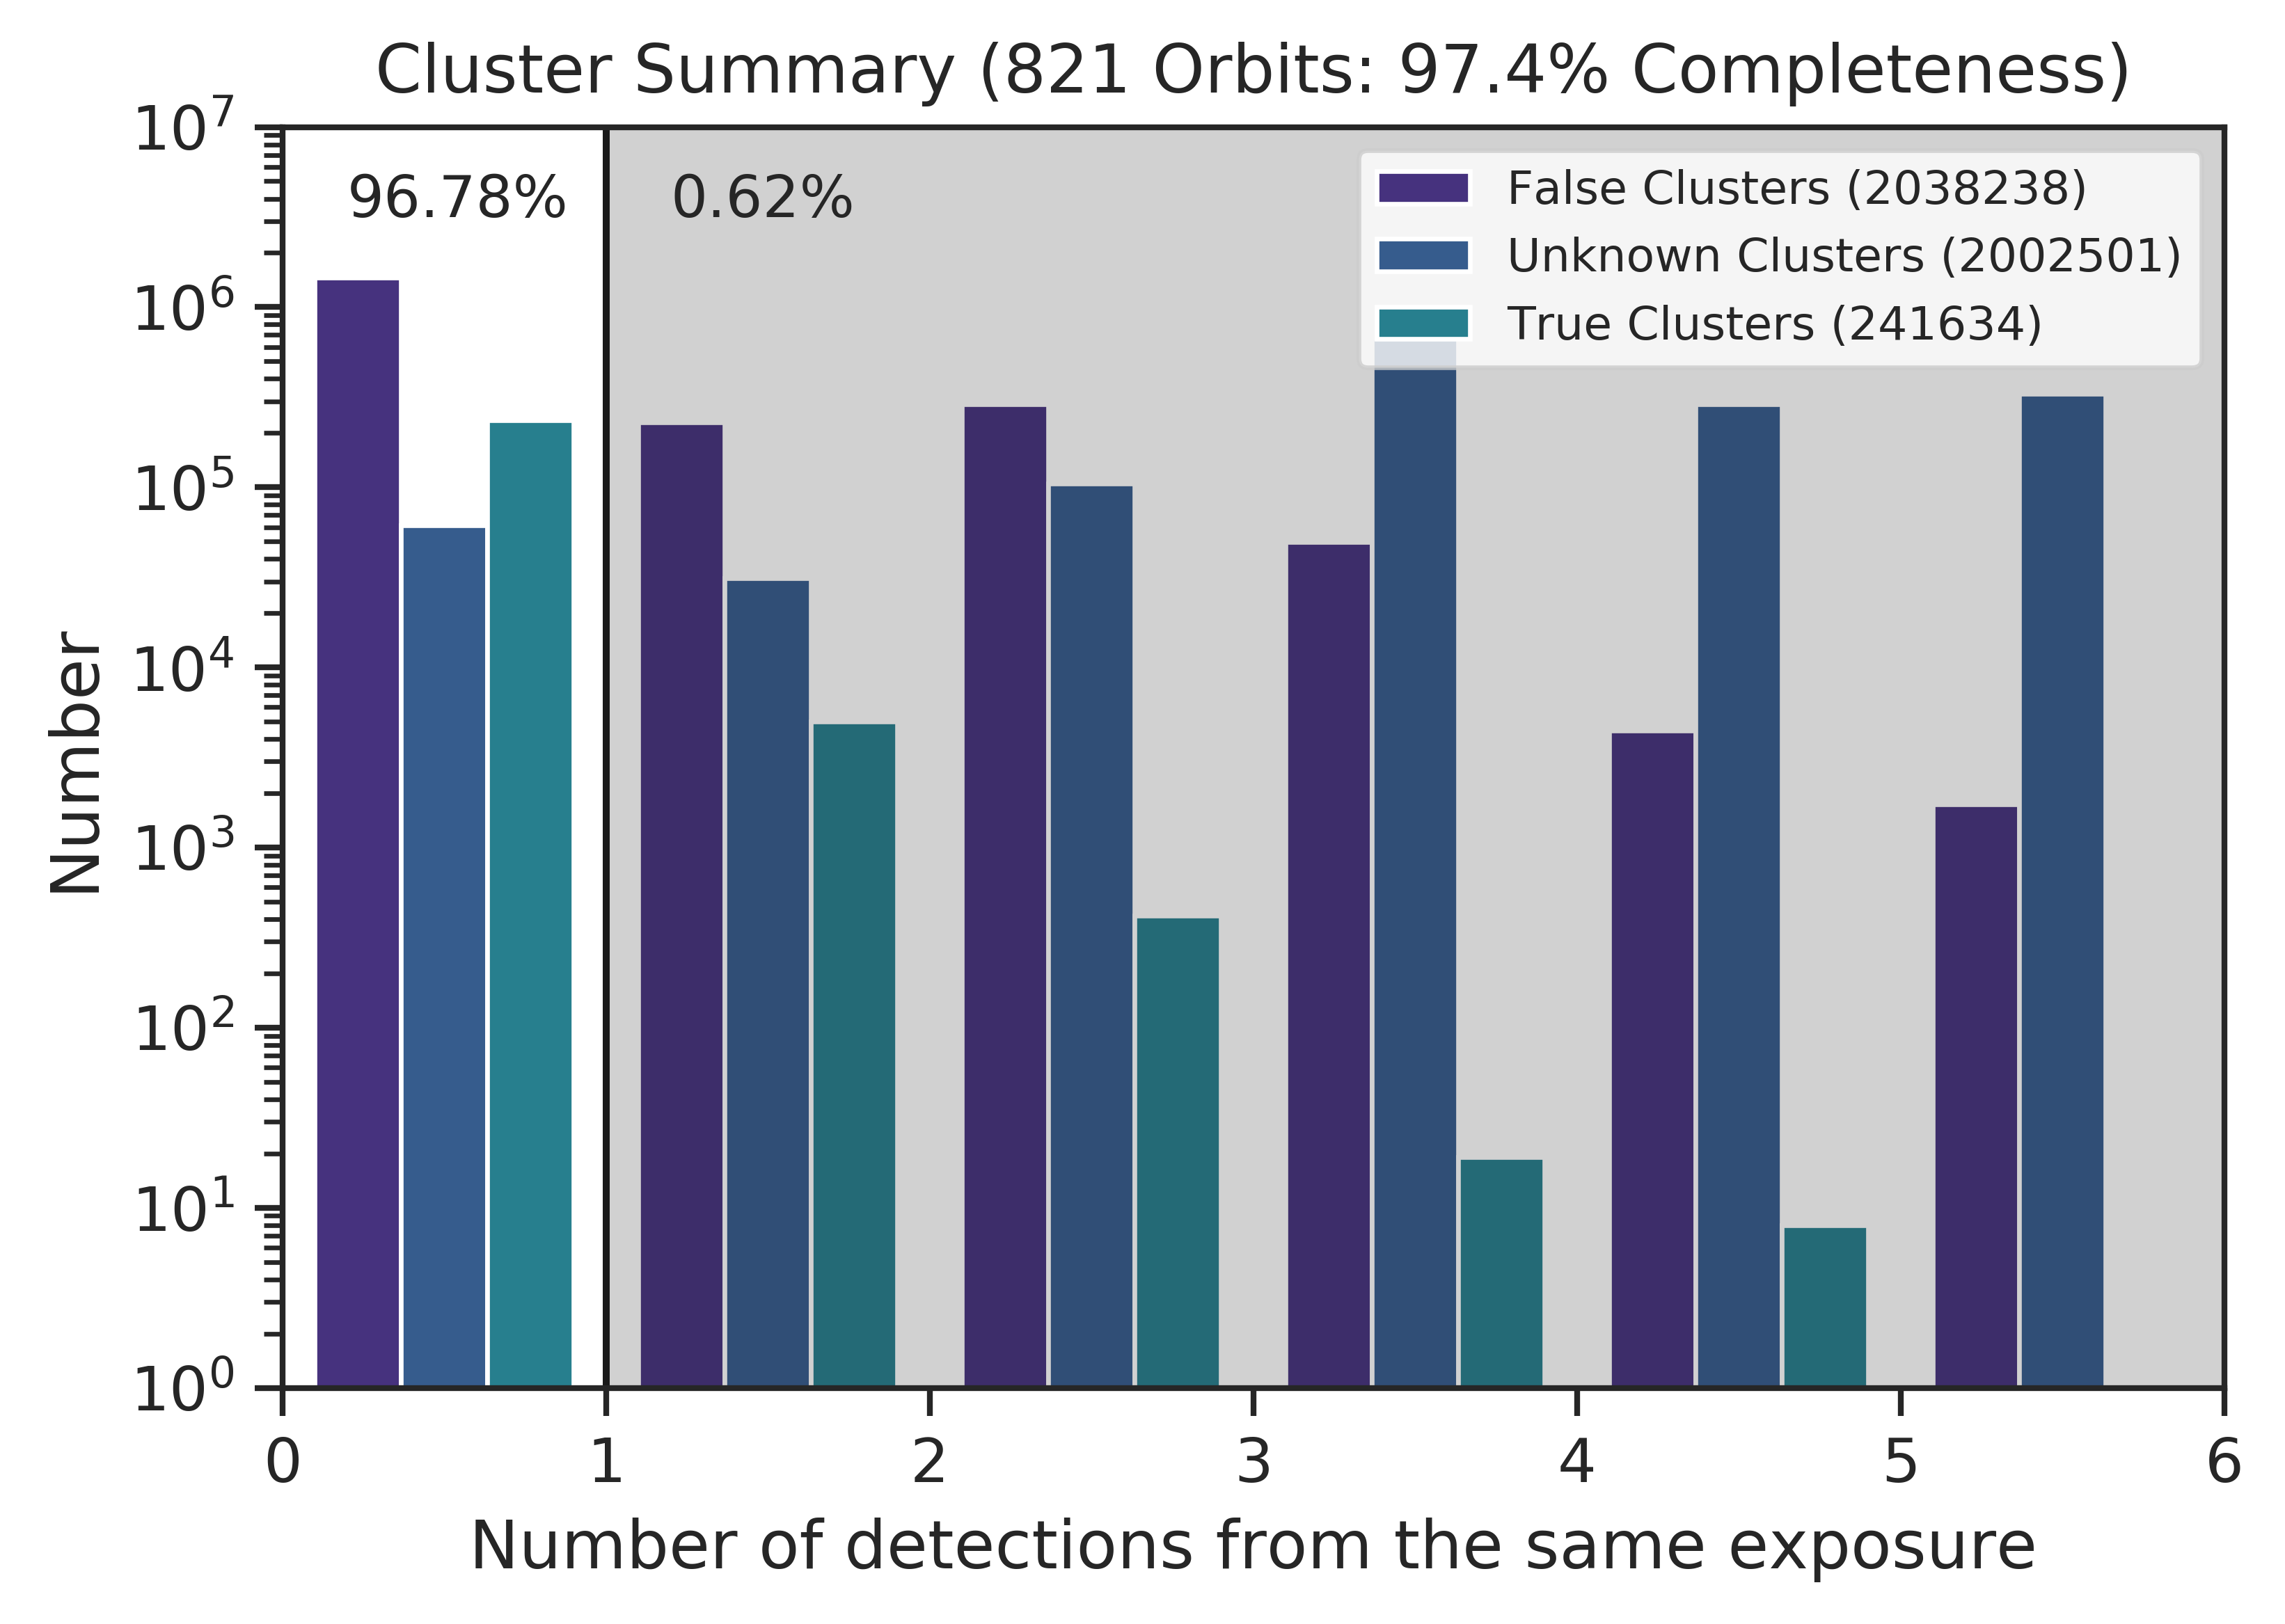

In [14]:
accepted_clusters = allClusters_projection[(~allClusters_projection["linked_object"].isna()) 
                                           & (~allClusters_projection["linked_object"].isin(falsePositiveIDs + unknownIDs))]
a = set(accepted_clusters[accepted_clusters["num_dupes"] == 0]["linked_object"].unique())
b = set(accepted_clusters[accepted_clusters["num_dupes"] > 0]["linked_object"].unique())


fig, ax = plt.subplots(1, 1, dpi=600)
ax.hist([allClusters_projection[allClusters_projection["linked_object"].isna()]["num_dupes"].values, 
         allClusters_projection[allClusters_projection["linked_object"].isin(unknownIDs)]["num_dupes"].values,
         allClusters_projection[(~allClusters_projection["linked_object"].isin(falsePositiveIDs + unknownIDs) & (~allClusters_projection["linked_object"].isna()))]["num_dupes"].values], 
        bins=range(7), 
        label=["False Clusters ({})".format(len(allClusters_projection[allClusters_projection["linked_object"].isna()])), 
               "Unknown Clusters ({})".format(len(allClusters_projection[allClusters_projection["linked_object"].isin(unknownIDs)])),
               "True Clusters ({})".format(len(allClusters_projection[((allClusters_projection["partial"] == 1) | (allClusters_projection["pure"] == 1)) & (~allClusters_projection["linked_object"].isin(falsePositiveIDs + unknownIDs))]))])
ax.legend(fontsize=8)
ax.set_xlabel("Number of detections from the same exposure")
ax.vlines(1, 1, 10**7)
ax.set_yscale("log")
ax.set_ylim(1, 10**7)
ax.text(0.2, 10**6.5, "{:0.2f}%".format(len(a) / 21401 * 100))
ax.text(1.2, 10**6.5, "{:0.2f}%".format(len(b.difference(a)) / 21401 * 100))
ax.axvspan(1, 6, color="k", alpha=0.2)
ax.set_xlim(0, 6)
ax.set_title("Cluster Summary (821 Orbits: 97.4% Completeness)")
ax.set_ylabel("Number")
if SAVE_FIGS == True:
    fig.savefig(os.path.join(SAVE_DIR, "ztf_cluster_summary.{}".format(FORMAT)),
            bbox_inches='tight')